### 📌 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
import os
import re

In [ ]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
import tensorflow.keras

#os.chdir('/content/drive/MyDrive/클라우드 플랫폼/팀 프로젝트 (클플)/Final Data')
os.chdir('/content/drive/MyDrive/클라우드플랫폼2022/최종프로젝트')

input_shape = (224, 224, 3)

mobilenet_model = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
                                              input_shape=input_shape)

#output = mobilenet.layers[-1].output
#output = tensorflow.keras.layers.Flatten()(output)

#mobilenet_model = Model(mobilenet.input, output)
mobilenet_model.trainable = False

for layer in mobilenet_model.layers:
    layer.trainable = False

mobilenet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30, 
                                  # shear_range=5.5,  
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='reflect')

train_generator = train_datagen.flow_from_directory('./model_data_224/혼합_자세/train',
                                                    target_size=(224, 224),       #코드 변경
                                                    batch_size=5,
                                                    classes = ['good', 'bad'],    # 코드 추가
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('./model_data_224/혼합_자세/test',
                                                    target_size=(224, 224),       #코드 변경
                                                    batch_size=5,
                                                    classes = ['good', 'bad'],    # 코드 추가
                                                    class_mode='binary')

Found 448 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'good': 0, 'bad': 1}


## ✔️ 일반 Model

### 👉 epoch : 100 기준으로 돌리기 (model1)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model1 = Sequential()
model1.add(mobilenet_model)
#model1.add(Dense(512, activation='relu'))
#model1.add(Dropout(0.3))
#model1.add(Dense(512, activation='relu'))
#model1.add(Dropout(0.3))
model1.add(Flatten())       #위에서 말고 여기서 추가
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
tf.random.set_seed(100)

batch_size = 20
num_classes = 2
epochs = 200    #EarlyStopping 적용(안돌아가면 30회)
input_shape = (224, 224, 3)   #코드 변경

MODEL_DIR = './model/'
if not os.path.exists('./model/'):
    os.mkdir('./model/')

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

history = model1.fit(train_generator, 
                    #  steps_per_epoch=100, 
                     epochs=epochs,
                     validation_data=test_generator, #validation_steps=4,
                     verbose=1, callbacks=[early_stopping_callback,checkpointer])

#print("\n-----------------------------")
#print(f"Training Accuracy: {round(history.history['accuracy'][-1], 4)}")
#print(f"Training Loss: {round(history.history['loss'][-1], 4)}")
#print(f"Validation Accuracy: {round(history.history['val_accuracy'][-1], 4)}")
#print(f"Validation Loss: {round(history.history['val_loss'][-1], 4)}")

patience = 20

print("\n-----------------------------")
print(f"Training Accuracy: {round(history.history['accuracy'][-1 * patience -1], 4)}")
print(f"Training Loss: {round(history.history['loss'][-1 * patience - 1], 4)}")
print(f"Validation Accuracy: {round(history.history['val_accuracy'][-1 * patience - 1], 4)}")
print(f"Validation Loss: {round(history.history['val_loss'][-1 * patience - 1], 4)}")

Epoch 1/200
90/90 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9330
Epoch 1: val_loss improved from inf to 0.24428, saving model to ./model/01-0.2443.hdf5
90/90 [==============================] - 8s 82ms/step - loss: 0.1672 - accuracy: 0.9330 - val_loss: 0.2443 - val_accuracy: 0.8882
Epoch 2/200
90/90 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9308
Epoch 2: val_loss did not improve from 0.24428
90/90 [==============================] - 7s 75ms/step - loss: 0.1752 - accuracy: 0.9308 - val_loss: 0.2581 - val_accuracy: 0.8816
Epoch 3/200
90/90 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9375
Epoch 3: val_loss improved from 0.24428 to 0.23573, saving model to ./model/03-0.2357.hdf5
90/90 [==============================] - 7s 80ms/step - loss: 0.1767 - accuracy: 0.9375 - val_loss: 0.2357 - val_accuracy: 0.8816
Epoch 4/200
90/90 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9554
Epoch

In [ ]:
MIX_MODEL_DIR = './model/mixed_data'
if not os.path.exists(MIX_MODEL_DIR):
    os.mkdir(MIX_MODEL_DIR)

#__ 부분: 본인 데이터 형식 적기
model1.save('mixed_data_mobilenetBasic_img_aug_cnn.h5')

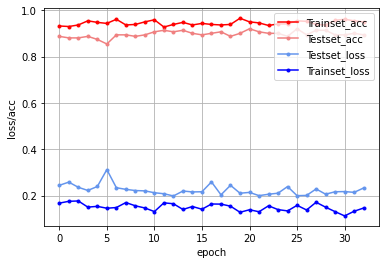

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='red', label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c='lightcoral', label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c='cornflowerblue', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()